# Airbnb Price Prediction for New Listings

## I. Introduction

Airbnb is a great platform that provides people online marketplace and service to arrange or offer lodging. The revenue of Airbnb in 2017 has exceeded $2.5 billion. As a travel enthusiast, Airbnb is always my first choice when I am planning a trip. For potential hosts, it might be difficult for them to decide the price of a totally new listing. As far as I know, there is no such a public model on Airbnb website for suggesting prices for new listings. So, in order to help potential hosts to get a descent idea on how much to charge for new listings, this project will build price prediction models for new listings on Airbnb. 

Fortunately, [Inside Airbnb](http://insideairbnb.com/get-the-data.html) has already aggregated all the publicly available informations from Airbnb site for public discussion. So, the dataset obtained from this website directly should be a good starting point for my machine learning model. In particular, I will the dataset collected in New York city compiled on 06 December, 2018. When selecting features for machine learning model, besides the variables provided in the datasets, the photo on the listing's website and the description of listing can be crucial for increasing the value of the listings. So, I will also analyze featured photos and text mining on the descriptions and take these two new features into considerations to see if performance of the prediction models can be improved. 

The project will be described as follows:
    1. Exploratory data analysis.
    2. Feature engineering (Image assessment on web photos and sentiment analysis on descriptions).
    3. Machine learning models and refinement.
    4. Future work.
    5. Conclusion.

In [636]:
import os
import numpy as np
import pandas as pd
import re
import math
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [637]:
df = pd.read_csv('listings.csv')
print ('There are {} rows and {} columns in the dataset'.format(*df.shape))
df.head(3)

There are 49056 rows and 96 columns in the dataset


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20181206022948,2018-12-06,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.42
1,21456,https://www.airbnb.com/rooms/21456,20181206022948,2018-12-06,Light-filled classic Central Park,"An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...","An adorable, classic, clean, light-filled one-...",none,"Diverse. Great coffee shops and restaurants, n...",...,f,NaN,NaN,f,f,moderate,t,t,1,0.72
2,2539,https://www.airbnb.com/rooms/2539,20181206022948,2018-12-06,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.25


In [3]:
# where to save figures and results
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
Image_Path = os.path.join(ROOT_DIR,'Images')

if not os.path.exists('Images'):
    os.makedirs('Images')
Image_path = os.path.join('Images')

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(Image_path,fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## II. Exploratory data  analysis and data preprocessing

There are 49056 observations and 96 columns in the dataset. However, not all the columns are needed for the model. Especially, for a new house, there won't be any information about reviews. So columns containing informations about reviews should be dropped. These features are "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month". After carefully considering each features, these features are kept for further data analysis: 
> - **listing_url:** from the url, photos of the listings can be scraped. Needless to say, an attractive featured photo of the listing can help to increase the value of the listings.<br>
- **description:** In description, host can emphasize the advantages of the listings. For example, phases like "1 min walk to subway", "beautiful view of Hudson river" can help tourists to make the decision.<br>
- **latitude, longitude, zipcode, neighbourhood_group_cleansed:** these four columns provide the information about the location.<br>
- **property_type, room_type, bathrooms, bedrooms, bed_type, square_feet:** these columns describe the properties of the listings, such as how large is the aparment, how many bathrooms or bedrooms it has.<br>
- **guests_included, cleaning_fee, extra_people, minimum_nights, maximum_nights, availability_365, cancellation_policy, security_deposit, host_is_superhost:** these columns provide informations about the policy of booking a room. The house with more flexible policy may be more prefered for some tourists who are not so sure about their schedules. <br>
- **id:** this id is kept for later image scraping.

The data cleaning process will be performed as follows:
1. Drop all the unnecessary columns.
2. "cleaning_fee","extra_people","price" have the dollar sign before the number. Need to remove the "\\$" and change the datetype from string to numerical values.
3. Categorical variables including "property_type","bed_type","room_type","cancellation_policy" contain types with only a few observations, so those categories can be combined into one category and name it "Other".
4. Handle missing values. First, columns including "bathrooms","bedrooms" and "price" have NULL values. They can be filled in with the median. Column "square_feet","cleaning_fee" and "security_deposi" have large proportions of missing values, these three variables will be dropped for further analysis.
5. Check the distribution of numerical variables. Some listings are extremely large (many bathrooms, bedrooms and can accommodate much more people), they need to be removed as outliers.

In [313]:
# drop all the unnecessary columns
feature_to_keep = ['listing_url','id','description','latitude','longitude','property_type','room_type','accommodates','bathrooms',
                  'bedrooms','bed_type','price','square_feet','guests_included','cleaning_fee','extra_people','minimum_nights',
                  'maximum_nights','availability_365','cancellation_policy','neighbourhood_group_cleansed','security_deposit','host_is_superhost']

new_df = df[feature_to_keep]

# remove the dollar sign before "cleaning_fee", "extra_people", "price" and change the datatype to numerical variables
feature_to_remove_dollar = ['cleaning_fee','extra_people','price']
new_df[feature_to_remove_dollar] = new_df[feature_to_remove_dollar].replace('\$','',regex = True)
new_df[feature_to_remove_dollar] = new_df[feature_to_remove_dollar].apply(pd.to_numeric,errors = "coerce")

In [314]:
# check the missing values
new_df.isna().sum()

listing_url                         0
id                                  0
description                       534
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          76
bedrooms                           49
bed_type                            0
price                             279
square_feet                     48590
guests_included                     0
cleaning_fee                    11079
extra_people                        0
minimum_nights                      0
maximum_nights                      0
availability_365                    0
cancellation_policy                 0
neighbourhood_group_cleansed        0
security_deposit                18087
host_is_superhost                   7
dtype: int64

In [315]:
# drop the column "square_feet" and "cleaning_fee"
new_df = new_df.drop(['square_feet','cleaning_fee','security_deposit'], axis = 1)

# drop 534 rows with missing descriptions
new_df['description'] = new_df['description'].dropna()

# fill NaN with median value for 'bathrooms', 'bedrooms','price'
new_df['bathrooms'] = new_df['bathrooms'].fillna(new_df['bathrooms'].median())
new_df['bedrooms'] = new_df['bedrooms'].fillna(new_df['bedrooms'].median())
new_df['price'] = new_df['price'].fillna(new_df['price'].median())

In [316]:
new_df['property_type'].value_counts()

Apartment                 39301
House                      3527
Townhouse                  1652
Loft                       1535
Condominium                1359
Serviced apartment          691
Guest suite                 258
Other                       129
Boutique hotel              112
Bed and breakfast           111
Resort                       89
Hotel                        75
Guesthouse                   56
Hostel                       48
Bungalow                     29
Villa                        25
Tiny house                   13
Aparthotel                   12
Boat                          8
Cottage                       5
Camper/RV                     4
Tent                          3
Earth house                   3
Cabin                         3
Casa particular (Cuba)        2
Island                        1
Cave                          1
Houseboat                     1
Bus                           1
Castle                        1
Nature lodge                  1
Name: pr

In [317]:
# merge small catergories in property_type into one category "Other"
Other = ['Serviced apartment','Guest suite','Other','Boutique hotel','Bed and breakfast','Resort','Hotel','Guesthouse',
        'Hostel','Bungalow','Villa','Tiny house','Aparthotel','Boat','Cottage','Camper/RV','Tent','Cabin','Earth house',
        'Casa particular (Cuba)','Cave','Bus','Castle','Island','Nature lodge','Houseboat']
new_df['property_type'].loc[new_df['property_type'].isin(Other)] = "Other"

In [318]:
new_df['room_type'].value_counts()

Entire home/apt    26059
Private room       21934
Shared room         1063
Name: room_type, dtype: int64

In [319]:
new_df['bed_type'].value_counts()

Real Bed         48156
Futon              338
Pull-out Sofa      285
Airbed             195
Couch               82
Name: bed_type, dtype: int64

In [320]:
# merge small catergories in bed_type into one category "No Bed"
Other = ['Futon','Pull-out Sofa','Airbed','Couch']
new_df['bed_type'].loc[new_df['bed_type'].isin(Other)] = "No Bed"

In [321]:
new_df['cancellation_policy'].value_counts()

strict_14_with_grace_period    22875
flexible                       14626
moderate                       11381
super_strict_60                  127
super_strict_30                   44
strict                             2
long_term                          1
Name: cancellation_policy, dtype: int64

In [322]:
# merge small catergories in cancellation_policy into one category "Other"
Other = ['super_strict_60','super_strict_30','strict','long_term']
new_df['cancellation_policy'].loc[new_df['cancellation_policy'].isin(Other)] = "Other"

Saving figure Distribution_of_variables
Dataset has 47199 rows and 20 columns.


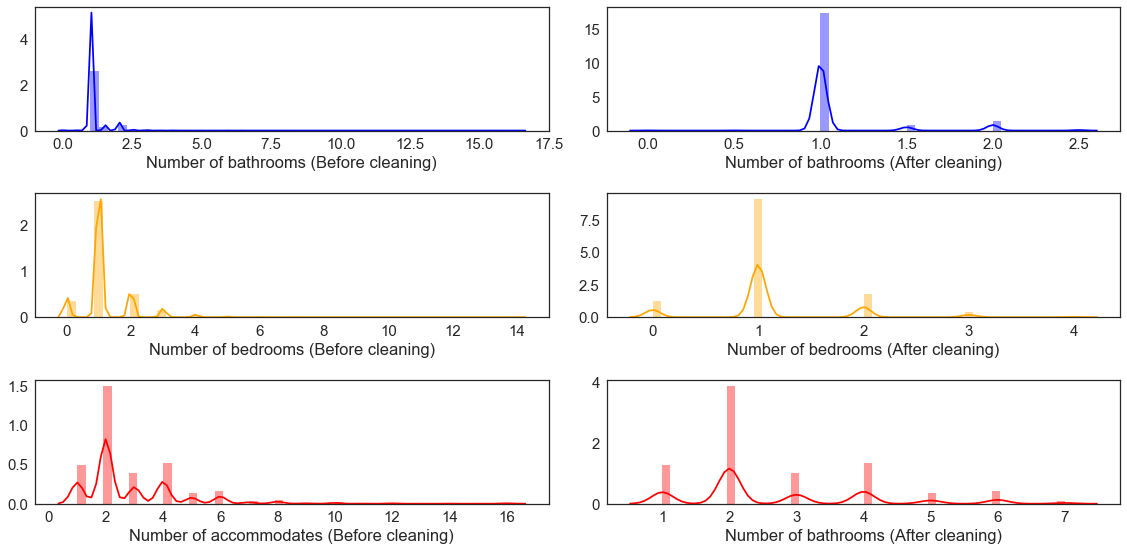

In [323]:
# check the distribution of Number of bedroom and Number of bathroom
%matplotlib inline
fig,axs = plt.subplots(ncols = 2, nrows = 3, figsize = (16,8))
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9,hspace=0.5,wspace=0.3)
sns.set(style = "white",font_scale=1.5)

sns.distplot(pd.Series(new_df['bathrooms'],name = "Number of bathrooms (Before cleaning)"),color = 'blue', ax = axs[0,0])
sns.distplot(pd.Series(new_df['bedrooms'], name = "Number of bedrooms (Before cleaning)"), color = "orange",ax = axs[1,0])
sns.distplot(pd.Series(new_df['accommodates'],name = "Number of accommodates (Before cleaning)"),color = 'red', ax = axs[2,0])

new_df = new_df[new_df['bathrooms']<3]
new_df = new_df[new_df['bedrooms']<5]
new_df = new_df[new_df['accommodates']<8]

sns.distplot(pd.Series(new_df['bathrooms'],name = "Number of bathrooms (After cleaning)"),color = 'blue', ax = axs[0,1])
sns.distplot(pd.Series(new_df['bedrooms'], name = "Number of bedrooms (After cleaning)"), color = "orange",ax = axs[1,1])
sns.distplot(pd.Series(new_df['accommodates'],name = "Number of bathrooms (After cleaning)"),color = 'red', ax = axs[2,1])

save_fig("Distribution_of_variables")

print ("Dataset has {} rows and {} columns.".format(*new_df.shape))

new_df.to_csv('cleaned_df.csv')

### Location analysis

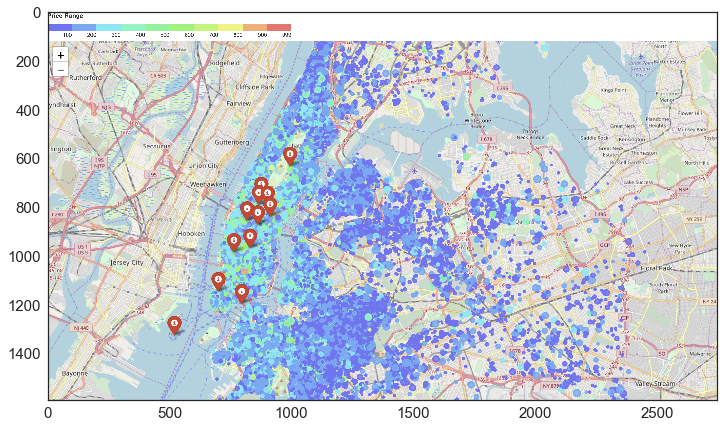

In [619]:
plt.figure(figsize = (12, 10))
img = scipy.misc.imread('map.png')
plt.imshow(img);

In [324]:
df_location = new_df.groupby('neighbourhood_group_cleansed',as_index = False).aggregate({
    'price':['mean','median'],
    'accommodates':'mean'
})
df_location['count'] = new_df['neighbourhood_group_cleansed'].value_counts().tolist()
df_location

neighbourhood_group_cleansed       price        accommodates  count
                                      mean median         mean       
0                        Bronx   77.976163   65.0     2.474461  21841
1                     Brooklyn  109.634747   90.0     2.631191  19121
2                    Manhattan  170.643469  145.0     2.726157   5063
3                       Queens   88.036737   72.0     2.552834    881
4                Staten Island   78.000000   66.0     2.788396    293

#### Comparison among different neighborhoods

Saving figure Price comparison among different neighborhoods


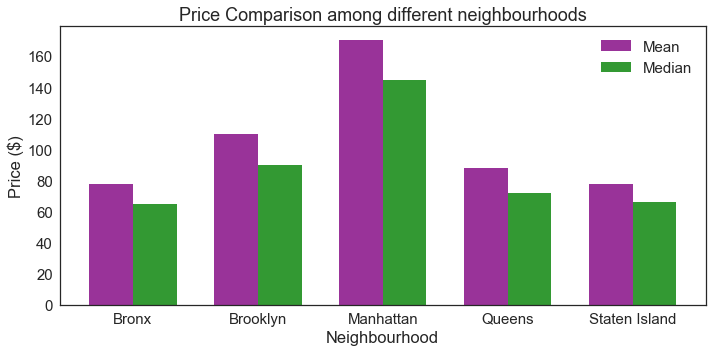

In [327]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,5))
index = np.arange(5)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(df_location['neighbourhood_group_cleansed'], df_location['price']['mean'], bar_width,
alpha=opacity,
color='purple',
label='Mean')
 
rects2 = plt.bar(index + bar_width,df_location['price']['median'], bar_width,
alpha=opacity,
color='g',
label='Median')
 
plt.xlabel('Neighbourhood')
plt.ylabel('Price ($)')
plt.title('Price Comparison among different neighbourhoods')
plt.xticks(index + 0.5*bar_width, df_location['neighbourhood_group_cleansed'])
plt.legend()
 
plt.tight_layout() 
save_fig("Price comparison among different neighborhoods")

plt.show()

Saving figure Comparison among different neighborhoods


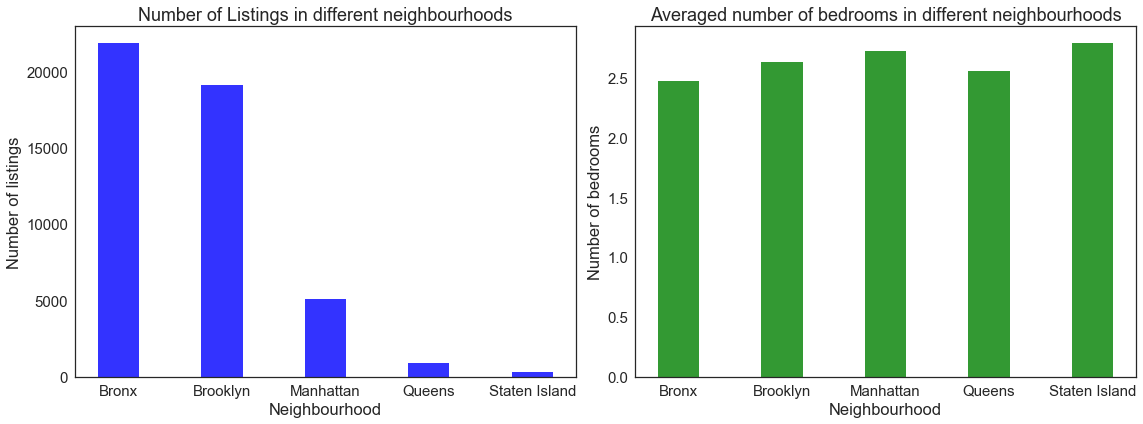

In [329]:
%matplotlib inline
fig,axs = plt.subplots(ncols = 2,figsize = (16,6))
bar_width = 0.40
opacity = 0.8

plt.subplot(1, 2, 1)
plt.bar(df_location['neighbourhood_group_cleansed'], df_location['count'], bar_width,
alpha=opacity,
color='blue')

plt.xlabel('Neighbourhood')
plt.ylabel('Number of listings')
plt.title('Number of Listings in different neighbourhoods')
 
plt.subplot(1, 2, 2)
plt.bar(df_location['neighbourhood_group_cleansed'], df_location['accommodates']['mean'], bar_width,
alpha=opacity,
color='green')

plt.xlabel('Neighbourhood')
plt.ylabel('Number of bedrooms')
plt.title('Averaged number of bedrooms in different neighbourhoods')

plt.tight_layout()
save_fig("Comparison among different neighborhoods")
plt.show()

## III. Feature Engineering

When I am looking for a place to stay on Airbnb, I always first check the photos of the listing: do they look attractive to me? Then I usually take a look of the description of the listings: Is the text showing me a comfortable room to live? So, based on my personal experience, an attractive photos and a pleasant description can be helpful to increase the value of the listings. In this part, I will focus on engineering two feaures: rate the attractiveness of each photos and topic modeling on description of the listings.

### Photo analysis

In most cases, hosts on Airbnb will upload some photos of their houses. These photos, especially the featured photo on the website, are extremely important to attract more viewers. An ideal photo should have desirable resolution and also be aesthetically attractive. Here I will use __[NIMA: Neural Image Assessment](https://ai.googleblog.com/2017/12/introducing-nima-neural-image-assessment.html)__ to score image quality. In NIMA, a deep convolutional neural network (CNN) is trained to predict whether the image will rated by a viewer as looking good (technically) and attractive (aesthetically). 

To assess both resolution and perceptual quality,  the model first initialize weights from object recognition networks, such as ImageNet, to understand general classification of objects. Then the perceptual quality assessment is achieved by fine-tuning on annotated data. This NIMA model gives a distribution of ratings for a given image on scale of 1 to 10 and also assign the probabilities. NIMA has been tested on Aesthetic Visual Analysis (AVA) datasets, and the rank given by NIMA matches closely the mean scores given by human raters.  

Here, I will use the pre-trained the NIMA model [Github](https://github.com/titu1994/neural-image-assessment) to predict the image score for each featured photo on the website and this score will be incorporated as a new feature for machine learning model. The workflow will be as follows:

1. Use beautiful soup to scrape images from the url link of the listed houses.
2. Predict the image score use NIMA model.


In [16]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import scipy.misc

In [17]:
new_df = new_df.reset_index()

In [74]:
# extract the url for the web photo from 'listings_url'
listings = new_df['listing_url']
image_link = {}
for i in range(len(listings)):
    file_url = listings[i]
    page = requests.get(file_url)    
    soup = BeautifulSoup(page.text,"html.parser")
    img_tags = soup.find_all('img')
    img_urls = [img['src'] for img in img_tags]
    for url in img_urls:
        if not url.startswith("https://a0.muscache.com/im/pictures/"):
            continue
        image_link_1[file_url] = url
      # print (len(image_link))
      # np.save('imagelink_dic.npy',image_link)
        break

In [166]:
# save the link and the dataframe
new_df['image_link'] = new_df['listing_url'].map(image_link)
new_df.to_csv('new_df_imagelink.csv')

In [227]:
# some listings are no longer available and there is no photo for them
df_imagelink = df_imagelink.dropna(subset=['image_link'])

12588

In [247]:
df_imagelink.to_csv('webphoto_link.csv')

In [235]:
# set up the path for the photos output
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
Photo_Path = os.path.join(ROOT_DIR,'Photos')

if not os.path.exists('Photos'):
    os.makedirs('Photos')
Photo_path = os.path.join('Photos')

# scraping images from the link
df_imagelink = df_imagelink[['id','image_link']].reset_index()

for i in range(len(df_imagelink)):
   # link = df_image['image_link'][i]
    link = df_imagelink['image_link'][i]
   # print (url_link)
    photo_id = df_imagelink['id'][i]
    image_name = os.path.join(Photo_Path,str(photo_id)+str('.jpg'))

    if not os.path.isfile(image_name):
        f = open(image_name,'wb')
        f.write(requests.get(link).content)
        f.close()

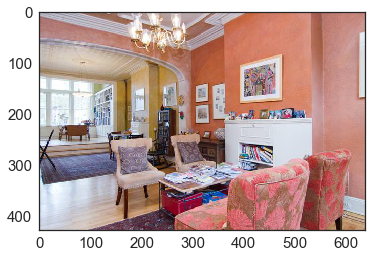

In [242]:
# take random samples and check if their NIMA scores make sense
sample = df_imagelink['image_link'][25]
photo_id = df_imagelink['id'][25]
image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))
img = scipy.misc.imread(image_name)
plt.imshow(img)

In [244]:
# use NIMA model to score images
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from utils import mean_score, std_score

NIMA_dic = {}
image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))

with tf.device('/CPU:0'):
    base_model = MobileNet((None, None, 3), alpha=1, include_top=False, pooling='avg', weights=None)
    x = Dropout(0.75)(base_model.output)
    x = Dense(10, activation='softmax')(x)

    model = Model(base_model.input, x)
    model.load_weights('weights/mobilenet_weights.h5')
        
    for i in range(len(df_imagelink)): 
        try:
            photo_id = df_imagelink['id'][i]
            image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))
        

            img = load_img(image_name)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            scores = model.predict(x, batch_size=1, verbose=0)[0]

            mean = mean_score(scores)
            std = std_score(scores)
            NIMA_dic[photo_id] = mean
            #print("NIMA Score : %0.3f +- (%0.3f)" % (mean, std))
        except:
            pass

In [248]:
# add NIMA_score to new_df
new_df['NIMA_score'] = new_df['id'].map(NIMA_dic)

# fill Null values with median
new_df['NIMA_score'] = new_df['NIMA_score'].dropna()
new_df = new_df.dropna(subset = ['NIMA_score'])

# save file into a csv
new_df.to_csv('new_df_withNIMA.csv')

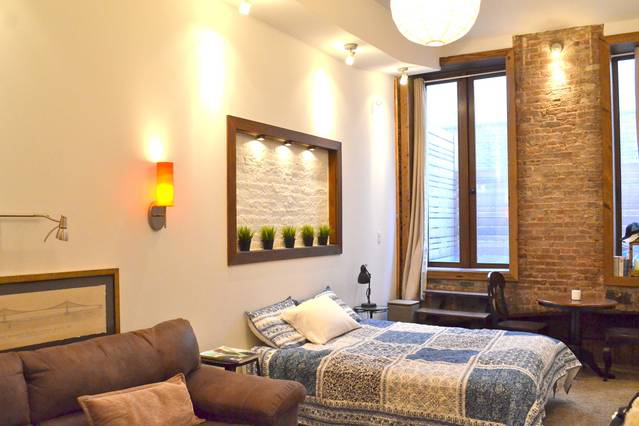

5.1056564404862


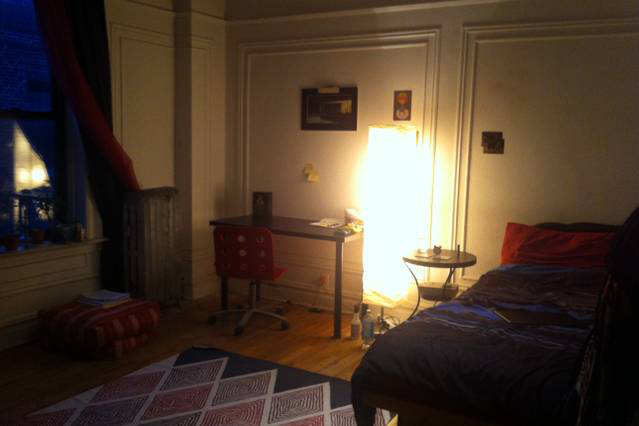

4.512407927075401


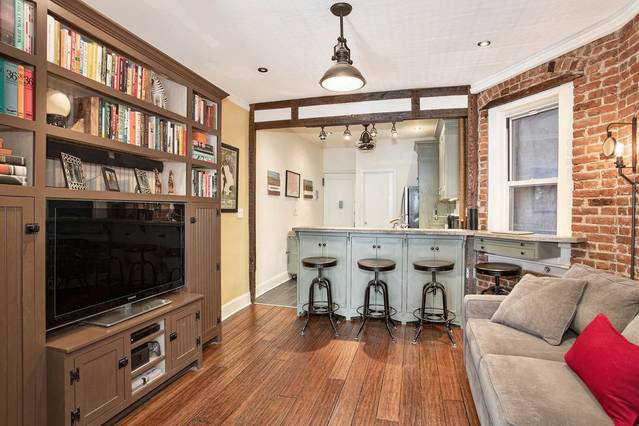

4.801112962886691


In [310]:
# pick some random samples to check if there score make sense
import random
samples = random.sample(range(10000),3)

from PIL import Image
for sample in samples:
    photo_id = new_df['id'][sample]
    image_name = os.path.join(Photo_path, str(photo_id)+str('.jpg'))
    display(Image.open(image_name))
    score = new_df['NIMA_score'][sample]
    print (score)

### Sentiment analysis on description

Description of the houses also has a great impact on guest's decision. An appropriate description can not only provide viewers with more details of the room but also leave them good impressions of the living environment using phrases such as "comfortable", "lovely bedroom", "bright and sunny room". So this part will focus on extraccting useful features from description. __Nature language processing (NLP)__ and __topic modeling__ will be carried out to analyze the text in 'description'. 

Topic model is a widely used text-mining tools to discover the abstract "topics" hidden in a collection of documents. Here, __Latent Dirichlet Allocation (LDA)__ will be used to discover topics in each description. In LDA model, a generative Bayesian inference model is used to assign each document with a probability distribution over topics, where topics are probability over words. 

Before topic modeling, the number of corpus in each description needs to be reduced. Non-english words, stop words and non-alphanumeric strings will be removed. The remaining corpus will also be lemmatised so that only important  and meaningful words will be kept later sentiment analysis. The corpus then needs to be converted into a __Document-term-matrix__, where each row corresponding to the documents and column corresponding to the terms. 


The pipeline of topic modeling on text of description will be as follows:
1. Tokenize words, remove non-english words, stop words and non-alphanumeric strings, convert all letters to lower case, and lemmatize words.
2. Convert the remaining corpus into Document Term Matrix.
3. Apply LDA model to model topics.
4. Use pyLDAvis.gensim to visualize topics.
5. Assign each observation with the topics with highest probability.

In [253]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import json
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [254]:
def preprocess_text(corpus):
    processed_corpus = []
    english_words = set(nltk.corpus.words.words())
    english_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[A-Za-z|!]+')
    for row in corpus:
        sentences = []
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_english if not t in english_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        for word in word_tokens_no_stops_lemmatized:
            if len(word) >= 2:
                sentences.append(word)
        processed_corpus.append(sentences)
    return processed_corpus

def pipline(processed_corpus):
    dictionary = Dictionary(processed_corpus)
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in processed_corpus]
    return dictionary, doc_term_matrix

def lda_topic_model(doc_term_matrix,dictionary,num_topics = 3, passes = 2):
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix,num_topics = num_topics, id2word = dictionary, passes = passes)
    return ldamodel

def topic_feature(ldamodel,doc_term_matrix,df,new_col,num_topics):
    docTopicProbMat = ldamodel[doc_term_matrix]
    docTopicProbDf = pd.DataFrame(index = df.index, columns = range(0,num_topics))
    for i,doc in enumerate(docTopicProbMat):
        for topic in doc:
            docTopicProbDf.iloc[i,topic[0]] = topic[1]
    docTopicProbDf = docTopicProbDf.fillna(0)
    docTopicProbDf[new_col] = docTopicProbDf.idxmax(axis=1)
    df_topics = docTopicProbDf[new_col]
    df_new = pd.concat([df,df_topics],axis = 1)
    return df_new

In [255]:
corpus_description = new_df['description'].astype(str)

# use nlp package to process the text in description
processed_corpus_description = preprocess_text(corpus_description)

# generate the doc_term_matrix for lda model
dictionary_description, doc_term_matrix_description = pipline(processed_corpus_description)

# lda model for topic modeling
ldamodel_description = lda_topic_model(doc_term_matrix_description,dictionary_description)

# add the topic feature to the dataframe
final_df = topic_feature(ldamodel_description,doc_term_matrix_description,new_df,new_col = 'description_topic', num_topics =3)

# visualization of the lda model and save it as html page
p_description = pyLDAvis.gensim.prepare(ldamodel_description, doc_term_matrix_description, dictionary_description)
pyLDAvis.save_html(p_description,'lda_description.html')

pyLDAvis package is a great package to visualize the LDA model. The area of the circles means the prevalence of each topic. Here I chose the cluster the corpus into three topics. The red bar represents the estimated term frequency within selected topic and the blue bar represents the overall term frequency. In topic 1, the prevalent term is about the transit of the listings, for example, there are words "walk", "train", "away". Topic 2 is about the neighborhood because it has words "city","neighborhood","york","park". Topic 3 is correlated with utility of the house shown by words "floor", "large","space","private".

In [256]:
p_description

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      34.191521        1       1 -0.040344  0.071945
0      33.533745        1       2 -0.076548 -0.058480
2      32.274742        1       3  0.116892 -0.013465, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
564   Default  11373.000000        place  11373.000000  30.0000  30.0000
73    Default  16009.000000        train  16009.000000  29.0000  29.0000
44    Default  39387.000000         room  39387.000000  28.0000  28.0000
463   Default   8635.000000          min   8635.000000  27.0000  27.0000
53    Default  18104.000000         walk  18104.000000  26.0000  26.0000
4     Default  19212.000000          bed  19212.000000  25.0000  25.0000
41    Default   8981.000000        queen   8981.000000  24.0000  24.0000
152   Default  16001.000000          new  16001.000000  23.0000  23.0000
292   Default   7245.000000         york   7245.000000  22.0000  22.0000
2     Default  16717.000000     bathroom  16717.000000  21.0000  21.0000
5     Default  27883.000000      bedroom  27883.000000  20.0000  20.0000
63    Default   4304.000000          bus   4304.000000  19.0000  19.0000
409   Default   6573.000000      station   6573.000000  18.0000  18.0000
404   Default   7516.000000       minute   7516.000000  17.0000  17.0000
136   Default  16815.000000         away  16815.000000  16.0000  16.0000
106   Default  10728.000000        large  10728.000000  15.0000  15.0000
47    Default   9029.000000         size   9029.000000  14.0000  14.0000
231   Default   7185.000000        fully   7185.000000  13.0000  13.0000
9     Default  11361.000000         city  11361.000000  12.0000  12.0000
107   Default   4357.000000         love   4357.000000  11.0000  11.0000
104   Default   5994.000000         high   5994.000000  10.0000  10.0000
206   Default  17485.000000      private  17485.000000   9.0000   9.0000
26    Default  14884.000000         full  14884.000000   8.0000   8.0000
111   Default   5296.000000       modern   5296.000000   7.0000   7.0000
31    Default  27555.000000      kitchen  27555.000000   6.0000   6.0000
1382  Default   2168.000000      airport   2168.000000   5.0000   5.0000
759   Default   3875.000000        table   3875.000000   4.0000   4.0000
473   Default   5954.000000         best   5954.000000   3.0000   3.0000
164   Default   3577.000000         sofa   3577.000000   2.0000   2.0000
655   Default   2251.000000   dishwasher   2251.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
602    Topic3   2795.760254       washer   3696.542725   0.8516  -5.4628
126    Topic3   1538.255127        speed   1840.665039   0.9514  -6.0602
605    Topic3   1785.091553      doorman   2220.862793   0.9125  -5.9114
109    Topic3   2674.998535     mattress   3613.944336   0.8300  -5.5069
4      Topic3  10676.646484          bed  19212.242188   0.5434  -4.1228
226    Topic3   3659.944580       dining   5317.479004   0.7573  -5.1934
294    Topic3   2428.107910        brand   3235.479980   0.8438  -5.6038
122    Topic3   2651.288330        sized   3643.912842   0.8129  -5.5158
47     Topic3   5459.877930         size   9029.380859   0.6278  -4.7934
26     Topic3   8093.464844         full  14884.516602   0.5216  -4.3998
62     Topic3   7584.901367     building  14290.913086   0.4974  -4.4647
5      Topic3  12576.583008      bedroom  27883.839844   0.3347  -3.9590
24     Topic3   6509.212402        floor  11883.748047   0.5289  -4.6177
31     Topic3  11551.696289      kitchen  27555.453125   0.2615  -4.0440
1      Topic3  16086.717773    apartment  46094.480469   0.0782  -3.7129
150    Topic3   8030.548828       living  19018.550781   0.2687  -4.4076
44     Topic3  10846.741211         room  39387.707031  -0.1587  -4.1070
152    Topic3   6030.175293          

In [259]:
final_df.to_csv('final_df.csv')

## IV. Prediction model

In this part, __linear regression__ and __random forest algorithm__ will be applied to the clean dataset and predict the price. Linear regression is a simple mode with good generalization while random forest model is more complex and can capture the nonlinear relationships in the dataset. From previous exploratory analysis, the distribution of price might be right-skewed. To double check how those outliers can influence the performance, models will be applied on the whole dataset and dataset without extremely high price separately. 

To measure the accuracy of the model, RMSE (root mean squared error) is used as evaluation metrics. The smaller RMSE, the better accuracy. The target for prediction is "price". Catergorical features also need to be converted to numerical features so that they can be fed into machine learning algorithms. To split the whole dataset into a training set and a testing set, the dataset will be randomly shuffled first and 25% will be used as the splitting ratio.

In order to evaluate how the two new features captured from photo and description of the listings can improve the performance of the model, both models with and without these two new features will be built.

The to-do list in this part is:

1. Clean-up the dataset: separate the "price" from the dataset, drop "zipcode","neighbourhood_group_cleansed" and convert catergorical variables into numerical features. Other columns including "level_0", "id", "listing_url", "description","image_link" can be dropped as well since they are not needed any more.
2. Split the dataset into a training set and a test set using 75:25 ratio and train the model.
3. Select the model with lowest RMSE value for further refinement.

In [348]:
final_df.head(5)

,level_0,index,listing_url,id,description,latitude,longitude,property_type,room_type,accommodates,...,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,cancellation_policy,NIMA_score,description_topic,host_is_superhost
1,1,1,https://www.airbnb.com/rooms/21456,21456,"An adorable, classic, clean, light-filled one-...",40.797642,-73.961775,Apartment,Entire home/apt,2,...,140.0,2,28.0,5,365,248,moderate,4.519021,2,f
2,2,2,https://www.airbnb.com/rooms/2539,2539,Renovated apt home in elevator building. Spaci...,40.647486,-73.972370,Apartment,Private room,4,...,149.0,1,25.0,1,730,365,moderate,5.003754,1,t
3,3,3,https://www.airbnb.com/rooms/2595,2595,"Find your romantic getaway to this beautiful, ...",40.753621,-73.983774,Apartment,Entire home/apt,2,...,225.0,2,0.0,1,1125,350,strict_14_with_grace_period,4.826283,2,f
4,4,4,https://www.airbnb.com/rooms/21644,21644,A great space in a beautiful neighborhood- min...,40.828028,-73.947308,Apartment,Private room,1,...,89.0,1,55.0,1,60,365,strict_14_with_grace_period,4.466677,0,f
6,6,6,https://www.airbnb.com/rooms/21794,21794,"It's comfy & has a loft bed & a chaise lounge,...",40.740085,-74.002706,Apartment,Private room,2,...,111.0,1,50.0,30,1124,359,strict_14_with_grace_period,5.036104,2,t


In [359]:
# features to keep
cols_to_keep = ['latitude','longitude','accommodates','bathrooms','bedrooms','guests_included','extra_people','maximum_nights','minimum_nights','property_type',
                'bed_type','room_type','cancellation_policy','NIMA_score','description_topic','host_is_superhost','price']
model_df = final_df[cols_to_keep]

# convert strings to dummies
categorical_feats = ['property_type','room_type','bed_type','cancellation_policy','host_is_superhost','description_topic']
model_df = pd.get_dummies(model_df,columns = categorical_feats,drop_first = False)

# separate the target variable "yield" from the dataset
target = model_df['price']
X_df = model_df.drop(['price'],axis = 1)

### Remove luxury listings

Before building the model, I checked the distribution of the target value. The distribution of listings's price is skewed towards the lower price. Almost all the prices are lower than \\$500, only a few listings have prices higher than \\$500. These listings may be outliers and influence the performance the model. To make sure this point, models on all the prices and on listings with prices lower than \\$500 will be trained separately. 

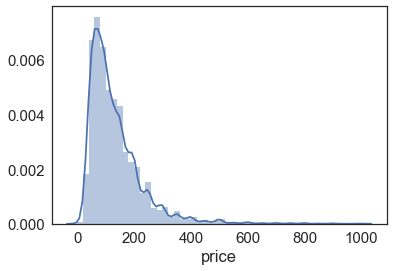

In [356]:
sns.distplot(pd.Series(target))

#### Linear regression on all the dataset

In [396]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

seed = 42
X_train,X_test,y_train,y_test = train_test_split(X_df,target,random_state=seed)
linreg = LinearRegression().fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
print("Root Mean squared error: %.3f" %np.sqrt(mean_squared_error(y_test,y_pred_linreg)))
rmse_lr = np.sqrt(mean_squared_error(y_test,y_pred_linreg))

Root Mean squared error: 73.636


#### Random forest on all the dataset

In [397]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor().fit(X_train,y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Root Mean squared error: %.3f" %np.sqrt(mean_squared_error(y_test,y_pred_rf)))
rmse_rf = np.sqrt(mean_squared_error(y_test,y_pred_linreg))

Root Mean squared error: 65.968


#### Linear regression on houses with price <500

In [434]:
# drop those luxury houses
model_df_500 = model_df[model_df['price']<500]
# separate the target variable "yield" from the dataset
target_500 = model_df_500['price']
X_df_500 = model_df_500.drop(['price'], axis = 1)

print ("Final dataset has {} rows, {} columns.".format(*model_df_500.shape))

Final dataset has 33407 rows, 31 columns.


In [606]:
X_train,X_test,y_train,y_test = train_test_split(X_df_500,target_500,random_state=seed)
linreg = LinearRegression().fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
print("Root Mean squared error: %.3f" %np.sqrt(mean_squared_error(y_test,y_pred_linreg)))
rmse_lr_500 = np.sqrt(mean_squared_error(y_test,y_pred_linreg))

Root Mean squared error: 56.622


#### Random forest on houses with price<500

In [504]:
rf_reg = RandomForestRegressor().fit(X_train,y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Root Mean squared error: %.3f" %np.sqrt(mean_squared_error(y_test,y_pred_rf)))

Root Mean squared error: 51.240


#### Comparsion of performance on two datasets

Saving figure Comparison of model performance on different datasets


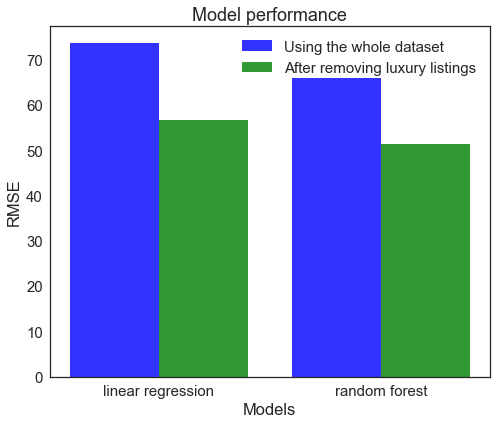

In [443]:
%matplotlib inline
models = ['linear regression','random forest']
rmse_whole = [73.636,65.968]
rmse = [56.622,51.349]


fig,axs = plt.subplots(figsize = (7,6))
bar_width = 0.40
opacity = 0.8
 
rects1 = plt.bar(index, rmse_whole, bar_width,
alpha=opacity,
color='b',
label='Using the whole dataset')
 
rects2 = plt.bar(index + bar_width, rmse, bar_width,
alpha=opacity,
color='g',
label='After removing luxury listings')
 
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model performance')
plt.xticks(index + 0.5*bar_width, ('linear regression','random forest'))
plt.legend()
 
plt.tight_layout()
save_fig('Comparison of model performance on different datasets')
plt.show()

After removing luxury listings, the performance of both linear regression and random forest are improved. So, the dataset without prices higher than \\$500 will be used. Also, from this quick test, random forest gave better RMSE than linear regression. Hence, random forest is chosen for later fine-tuning.

### Fine tuning the random forest model

In [412]:
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators" :[150,175,200,225,250,300],
             "criterion": ['mse'],
             "max_features": ['auto'],
             "max_depth": [3,5,7,9,11,15,20],
             "min_samples_split":[4,6,8,10,12],
             "bootstrap":[True]}

rf_fine = RandomForestRegressor(random_state = seed)
rf_cv = GridSearchCV(rf_fine,param_grid,cv=5).fit(X_train,y_train)
y_rf_cv_pred = rf_cv.predict(X_test)
print("Root Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_rf_cv_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_rf_cv_pred))
print("Best Parameters: {}".format(rf_cv.best_params_))

Root Mean squared error: 48.840
Variance score: 0.630
Best Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 300}


In [604]:
# save the model
from sklearn.externals import joblib 
rf_reg = rf_cv.best_estimator_
joblib.dump(rf_cv, "model.pkl")

['model.pkl']

### Model sensitivity

To test the robustness of the model, the model will run on different splittings of training and test sets 100 times. The RMSE value gave a normal distribution and a 95% confident interval is XXX.

In [628]:
import random

random_seed = random.sample(range(1000), 500)
rmse = []
for seed in random_seed:
    X_train,X_test,y_train,y_test = train_test_split(X_df_500,target_500,random_state=seed)
    rf_reg = rf_reg.fit(X_train,y_train)
    y_rf_pred = rf_reg.predict(X_test) 
    rmse_temp = np.sqrt(mean_squared_error(y_test, y_rf_pred))
    rmse.append(rmse_temp)

In [635]:
import pickle
with open("rmse.txt", "wb") as fp:   #Pickling
    pickle.dump(rmse, fp) 

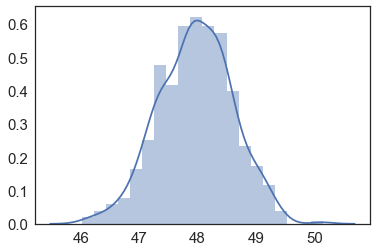

In [629]:
sns.distplot(rmse);

In [639]:
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
higher = mean_rmse + 1.96*std_rmse
lower = mean_rmse - 1.96*std_rmse

In [656]:
print ('95% confidence interval is: {:.3f} - {:.3f}'.format(lower,higher))

95% confidence interval is: 46.731 - 49.207


### Feature importance

In [477]:
feature_import = rf_reg.feature_importances_*100
feature_import = pd.DataFrame(list(zip(feature_import,X_train.columns.values)))
feature_import = feature_import.sort_values(by=0,axis=0,ascending=False)
feature_import.columns = ['importance %','feature']
print(feature_import[:20])

    importance %                                          feature
16     33.234713                        room_type_Entire home/apt
1      15.785836                                        longitude
0      13.153560                                         latitude
9       6.431818                                       NIMA_score
3       5.085877                                        bathrooms
4       4.813686                                         bedrooms
2       4.215171                                     accommodates
8       3.339125                                   minimum_nights
7       2.894336                                   maximum_nights
6       2.537586                                     extra_people
5       1.562831                                  guests_included
29      0.859737                              description_topic_2
10      0.768167                          property_type_Apartment
24      0.590900  cancellation_policy_strict_14_with_grace_period
22      0.

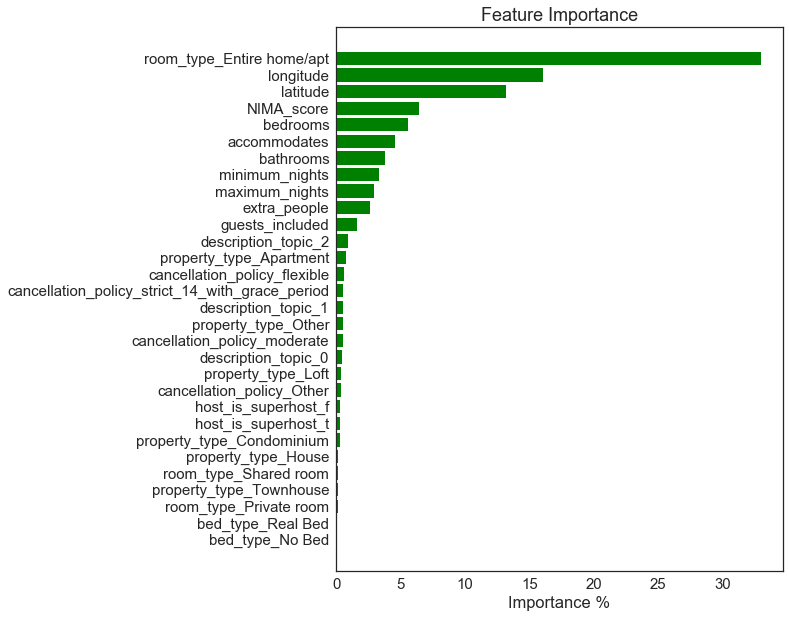

In [447]:
features = feature_import['feature']
importances = feature_import['importance %']

fig,ax = plt.subplots(figsize=(8,10))
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, align='center',color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance %')
ax.set_title('Feature Importance')

plt.show()

In the fine-tuned model, the type of the room and the location are top 3 important features. Interestingly, __NIMA_score__, the feature captured from web photos is ranked at __4th__ important feature (__6.4%__). The features from __description__ "description_topic_0",  "description_topic_1","description_topic_2" have combined __>1.8%__ of importance. 

In [481]:
# separate the target variable "yield" from the dataset and drop the features from web photos and descriptions
target_500_og = model_df_500['price']
X_df_500_og = model_df_500.drop(['price','NIMA_score','description_topic_0','description_topic_1','description_topic_2'], axis = 1)

In [419]:
X_train,X_test,y_train,y_test = train_test_split(X_df_500_og,target_500_og,random_state=seed)
param_grid = {"n_estimators" :[150,175,200,225,250,300],
             "criterion": ['mse'],
             "max_features": ['auto'],
             "max_depth": [3,5,7,9,11,15,20],
             "min_samples_split":[4,6,8,10,12],
             "bootstrap":[True]}

rf_fine_og = RandomForestRegressor(random_state = seed)
rf_cv_og = GridSearchCV(rf_fine_og,param_grid,cv=5).fit(X_train,y_train)
y_rf_cv_pred_og = rf_cv_og.predict(X_test)
print("Root Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_rf_cv_pred_og)))
print('Variance score: %.3f' % r2_score(y_test, y_rf_cv_pred_og))
print("Best Parameters: {}".format(rf_cv_og.best_params_))

Root Mean squared error: 48.862
Variance score: 0.630
Best Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 300}


### Model performance in different price ranges

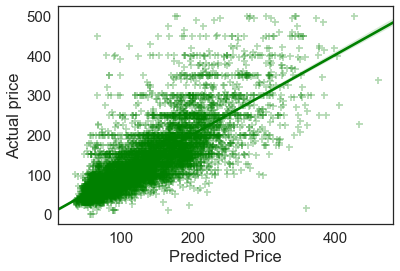

In [608]:
actual, predicted = pd.Series(y_test, name="Actual price"), pd.Series(y_rf_cv_pred, name="Predicted Price")
sns.regplot(predicted, actual, marker='+', scatter_kws={'alpha':0.3}, color = 'green');

#### price < 100

In [452]:
# drop those luxury houses
model_df_100 = model_df[model_df['price']<=100]
# separate the target variable "yield" from the dataset
target_100 = model_df_100['price']
X_df_100 = model_df_100.drop(['price'], axis = 1)

print ("Final dataset has {} rows, {} columns.".format(*model_df_100.shape))

Final dataset has 16712 rows, 31 columns.


In [502]:
X_train,X_test,y_train,y_test = train_test_split(X_df_100,target_100,random_state=seed)

In [454]:
rf_fine_100 = RandomForestRegressor(random_state = seed)
rf_cv_100 = GridSearchCV(rf_fine_100,param_grid,cv=5).fit(X_train,y_train)
y_rf_cv_pred_100 = rf_cv_100.predict(X_test)
print("Root Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_rf_cv_pred_100)))
print('Variance score: %.3f' % r2_score(y_test, y_rf_cv_pred_100))
print("Best Parameters: {}".format(rf_cv_100.best_params_))

Root Mean squared error: 15.871
Variance score: 0.417
Best Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 6, 'n_estimators': 300}


In [460]:
# save model
rf_reg_100 = rf_cv_100.best_estimator_
joblib.dump(rf_cv_100, "model_100.pkl")

['model_100.pkl']

#### Price in 100 ~ 300

In [456]:
model_df_300 = model_df[(model_df['price']>100)&(model_df['price']<=300)]

# separate the target variable "yield" from the dataset
target_300 = model_df_300['price']
X_df_300 = model_df_300.drop(['price'], axis = 1)

print ("Final dataset has {} rows, {} columns.".format(*model_df_300.shape))

Final dataset has 15535 rows, 31 columns.


In [457]:
X_train,X_test,y_train,y_test = train_test_split(X_df_300,target_300,random_state=seed)

In [459]:
rf_fine_300 = RandomForestRegressor(random_state = seed)
rf_cv_300 = GridSearchCV(rf_fine_300,param_grid,cv=5).fit(X_train,y_train)
y_rf_cv_pred_300 = rf_cv_300.predict(X_test)
print("Root Mean squared error: %.3f" % np.sqrt(mean_squared_error(y_test, y_rf_cv_pred_300))) 
print('Variance score: %.3f' % r2_score(y_test, y_rf_cv_pred_300))
print("Best Parameters: {}".format(rf_cv_300.best_params_))

Root Mean squared error: 41.680
Variance score: 0.342
Best Parameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 300}


In [462]:
# save model
rf_reg_300 = rf_cv_300.best_estimator_
joblib.dump(rf_cv_300, "model_300.pkl")

['model_300.pkl']

Text(0.5,1,'Performance on different price range')

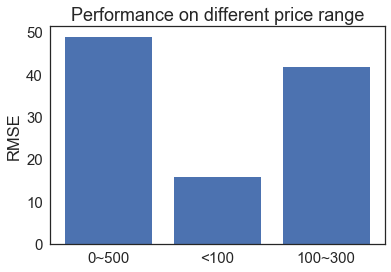

In [508]:
rmse = [48.840,15.871,41.680]
dataset = ['0~500','<100','100~300']
plt.bar(range(len(rmse)),rmse)
plt.xticks(range(len(rmse)),dataset)
plt.ylabel('RMSE')
plt.title('Performance on different price range')

This simple test shows that models trained on different price ranges gave different performance. Our model gave much lower RMSE on relatively cheap listings (price  < \\$100) while the RMSE increases when the model is trained on listings with higher price. This suggests that the data similarity between cheap listings and luxury listings might be poor, which might be the reason why the RMSE is quite high when using the whole dataset (price between \\$0 and \\$500). Data similarity among cheap listings might also be better than similarity among luxury listings, so the model performs better on cheap listings.


## VI. Future work

### Price range prediction

One major challenge in this project is that the responsive variable: price, is highly right skewed. The random forest model suffers the problem of data similarity. One possible solution is to predict price range instead of predicting the specific price itself. Previous studies have shown that for skewed dataset,classification model may give better prediction. Suggesting a price range is also more meangingful from practical point of view.

### Dynamic Pricing

InsideAirbnb also provides the information on prices on different days for each listings. The price of listings might be influenced by seasonality. Higher prices are charged during the peak season, or during special-event periods. So, further investigations can focus on how to predict price based on information of listings and also booking time.

In [538]:
df_calen = pd.read_csv('calendar.csv')
df_calen.head(5)

,listing_id,date,available,price
0,2515,2019-12-02,t,$89.00
1,21456,2019-12-05,t,$148.00
2,21456,2019-12-04,t,$148.00
3,21456,2019-12-03,t,$148.00
4,21456,2019-12-02,t,$148.00


In [561]:
import datetime

# convert the date to datetime format
df_calen['new_date'] = pd.to_datetime(df_calen['date'],format="%Y-%m-%d")


# delete the $ before price and convert it to numerical variable
df_calen['price'] = df_calen['price'].replace('\$','',regex = True)
df_calen['price'] = df_calen['price'].apply(pd.to_numeric,errors = "coerce")

# drop missing values in price
df_calen = df_calen.dropna()

#### Weekdays VS Weekends

First, I analyzed the price different between weekdays and weekends.Comparing the boxplot of price distribution, however, there seems to be no significant difference between weekdays and weekends.

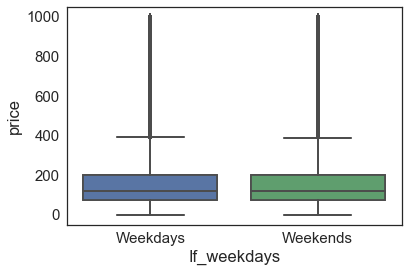

In [562]:
df_calen['weekdays'] = df_calen['new_date'].apply(lambda x: x.weekday())
df_calen_weekdays = df_calen[df_calen['weekdays']<5]
df_calen_weekends = df_calen[df_calen['weekdays']>4]
df_calen['If_weekdays'] = df_calen['weekdays'].apply(lambda x: 'Weekdays' if x<5 else 'Weekends') 

sns.boxplot(data = df_calen, x = 'If_weekdays', y = 'price', order = ['Weekdays','Weekends'])
sns.boxplot(data = df_calen, x = 'If_weekdays', y = 'price', order = ['Weekdays','Weekends'])

There seems to be no difference among different days in a week neither.

#### Price trend in  2019

In [564]:
df_2019 = df_calen[(df_calen['new_date']>='2018-01-01') & (df_calen['new_date']<='2019-12-31')]

df_2019 = df_2019.groupby('new_date',as_index = False).aggregate({
    'listing_id':'first',
    'price':['mean','median'],
    'weekdays':'first',
    'If_weekdays':'first'
})

Saving figure Price trend per day in 2019


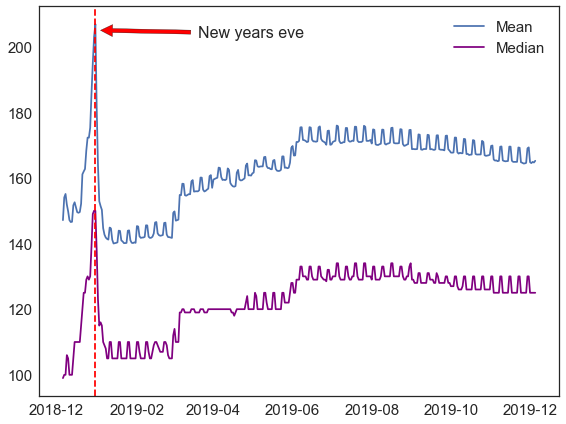

In [602]:
import matplotlib.dates as mdates
fig,axs = plt.subplots(figsize = (8,6))
plt.plot(df_2019['new_date'],df_2019['price']['mean'],label = "Mean")
plt.plot(df_2019['new_date'],df_2019['price']['median'],color = 'purple',label = "Median")
plt.axvline(x='2018-12-31',color ='r',linestyle = 'dashed')
plt.legend()
try:
    plt.annotate('New years eve',
             xy=('2018-12-31', 205),
             xytext = ('2019-03-20',203),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=16
            )
except:
    pass

save_fig('Price trend per day in 2019')

Saving figure price trend in first 70 days


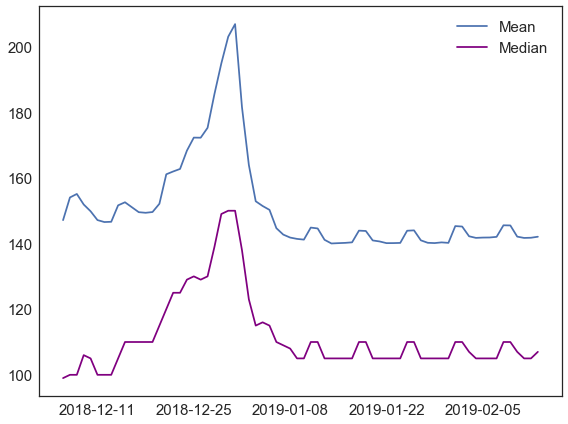

In [601]:
import matplotlib.dates as mdates
fig,axs = plt.subplots(figsize = (8,6))
plt.plot(df_2019['new_date'][0:70],df_2019['price']['mean'][0:70],label = "Mean")
plt.plot(df_2019['new_date'][0:70],df_2019['price']['median'][0:70],color = 'purple',label = "Median")
plt.legend()

save_fig('price trend in first 70 days')

Due to skewed data, mean is higher than median of the price, but they show similar trend: there is a weekly cyclicality trends of the data. So I plotted the price per day of the week.

Saving figure Averaged Price per Day  of the week


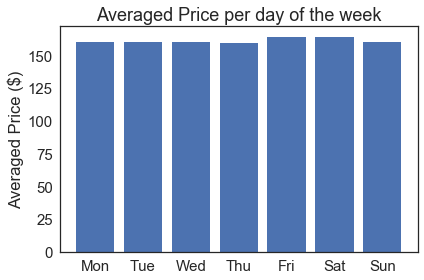

In [600]:
week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
week_data = df_calen.groupby('weekdays',as_index = False).aggregate({
    'price':'mean'
})

plt.bar(range(len(week_data)),week_data['price'])
plt.xticks(range(len(week_data)),week)
plt.ylabel('Averaged Price ($)')
plt.title('Averaged Price per day of the week')

save_fig('Averaged Price per Day  of the week')

The prices on Friday and Saturday are slightly higher. 

#### Seasonality

In [570]:
df_calen['month'] = df_calen['new_date'].apply(lambda x: x.month)

In [571]:
df_month = df_calen.groupby('month',as_index = False).aggregate({
    'price':'mean'
})

Saving figure Price trend in 2019


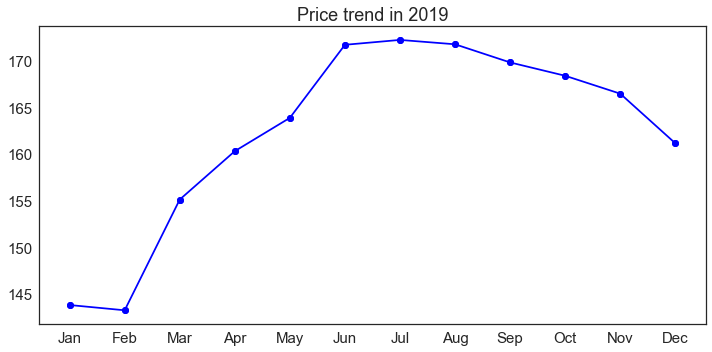

In [599]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig,axs = plt.subplots(figsize = (10,5))
plt.plot(range(len(months)),df_month['price'],'bo',range(len(months)),df_month['price'],'bo-')
plt.title('Price trend in 2019')
plt.xticks(range(len(months)),months);

save_fig('Price trend in 2019')

#### Price trend in July.

In [574]:
df_july = df_calen[df_calen['month']==7]

In [576]:
df_july.head(5)

,listing_id,date,available,price,new_date,weekdays,If_weekdays,month
464,30253778,2019-07-31,t,37.0,2019-07-31,2,Weekdays,7
465,30253778,2019-07-30,t,37.0,2019-07-30,1,Weekdays,7
466,30253778,2019-07-29,t,37.0,2019-07-29,0,Weekdays,7
467,30253778,2019-07-28,t,37.0,2019-07-28,6,Weekends,7
468,30253778,2019-07-27,t,37.0,2019-07-27,5,Weekends,7


In [578]:
df_july_days = df_july.groupby('new_date',as_index = False).aggregate({
    'price': 'mean'
})

Saving figure Price change in July


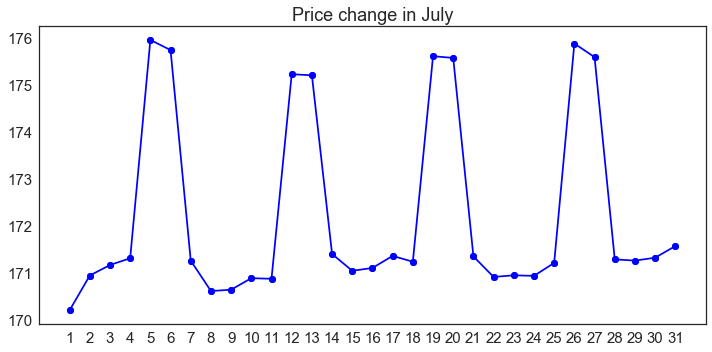

In [598]:
fig,axs = plt.subplots(figsize = (10,5))
plt.plot(range(1,len(df_july_days)+1),df_july_days['price'],'bo',range(1,len(df_july_days)+1),df_july_days['price'],'bo-')
plt.title('Price change in July')
plt.xticks(range(1,32));

save_fig('Price change in July')

#### Price trend in  December

In [583]:
df_december = df_calen[df_calen['month'] == 12]
df_december_days = df_december.groupby('new_date',as_index = False).aggregate({
    'price': 'mean'
})

Saving figure Price Change in  December


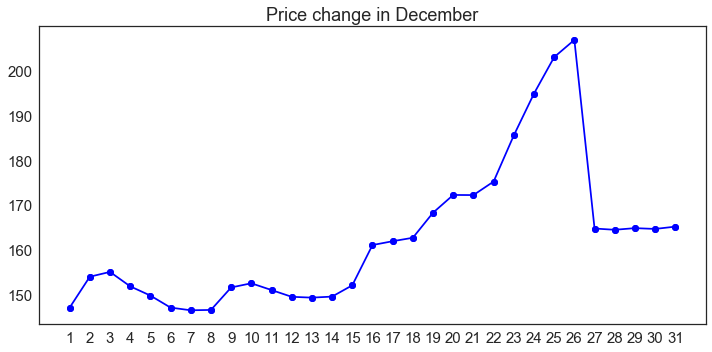

In [596]:
fig,axs = plt.subplots(figsize = (10,5))
plt.plot(range(1,len(df_december_days)+1),df_december_days['price'],'bo',range(1,len(df_december_days)+1),df_december_days['price'],'bo-')
plt.title('Price change in December')
plt.xticks(range(1,32));

save_fig('Price Change in  December')

Seasonality is important to estabilsh the price for a listing. Based on my preliminary exploratory analysis, here are my current conclusions:
1. There seems to be no obvious fluctuation in price. Overall, the price is higher in summer and lower in December, January and Feburary. This can be explained by the weather in New York. The winter in New York is always terribly cold sometimes with unexpected snowstorms. In summer, there are always various events or cultural festivals happending in the city.
2. Even though the averaged price in winter is lower than the price in other seasons, Christmas eve and New Year's eve have the highest prices of the year. 
3. There is a weekly cyclicality trends of the data. Within a week, the price in Friday and Saturday is slightly higher than other days in a  week.

Studying time-series models and predicting the trend of price will allow a much deeper understanding on determing the best price for a new listing, so further investigation will focus on studying the seasonal nature of the data.

## V. Conclusion

The original goal of this project is to apply machine learning algorithms to predict prices of new listings for potential hosts. Combined my own experience of browsing places to stay in Airbnb website, I added two additional features into the model: image score and topic modeling from web photos and descriptions. It turned out that these two features actually contain lots of valuable informations and are important features in the fine-tuned random forest model.

So far, the random forest model is not perfect yet due to the skewed distribution of price. Simply removing the listings with high price indeed can greatly improve the model. However, it doesn't mean that those luxury listings are not important. Models trained on different price ranges gave different performance. The model gave reasonable RMSE on cheap listings (price < \\$100) while the RMSE increases a lot when training on luxury listings. This suggest that the data similarity between cheap listings and luxury listings might be poor, which can influence the performance when training on the whole dataset. One possible solution is to predict the price range instead of predicting specific price, which will change this project into a classification problem. Other models such as SVM, XGBoost might also worth trying.

Another promising problem is dynamic pricing. Preliminary data analysis shows that the price of airbnb listings is influenced by holiday seasons. Also, price in summer is higher than other seasons in a year, Friday and Saturday have the highest price within a week. Thus, studing variaous seasonal time series models will be the next step.